In [23]:
%load_ext autoreload
%autoreload 2

import sys, os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from meta_neural_network_architectures import VGGReLUNormNetwork, ResNet12
from prompters import padding
from utils.parser_utils import get_args

import easydict

import torch
import torch.nn as nn
import numpy as np

import torch.backends.cudnn as cudnn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100
import torch.nn.functional as F
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
os.environ['DATASET_DIR'] = os.path.join(os.getcwd(), "datasets")

args = easydict.EasyDict(
{
  "batch_size":2,
  "image_height":84,
  "image_width":84,
  "image_channels":3,
  "gpu_to_use":0,
  "num_dataprovider_workers":4,
  "max_models_to_save":5,
  "dataset_name":"mini_imagenet_full_size",
  "dataset_path":"mini_imagenet_full_size",
  "reset_stored_paths":False,
  "experiment_name":"alfa+maml",
  "train_seed": 0, "val_seed": 0,
  "indexes_of_folders_indicating_class": [-3, -2],
  "sets_are_pre_split": True,
  "train_val_test_split": [0.64, 0.16, 0.20],
  "evaluate_on_test_set_only": False,

  "total_epochs": 100,
  "total_iter_per_epoch":500, "continue_from_epoch": -2,
  "num_evaluation_tasks":600,
  "multi_step_loss_num_epochs": 15,
  "minimum_per_task_contribution": 0.01,
  "learnable_per_layer_per_step_inner_loop_learning_rate": False,
  "enable_inner_loop_optimizable_bn_params": False,
  "evalute_on_test_set_only": False,

  "max_pooling": True,
  "per_step_bn_statistics": False,
  "learnable_batch_norm_momentum": False,
  "load_into_memory": False,
  "init_inner_loop_learning_rate": 0.01,
  "init_inner_loop_weight_decay": 0.0005,
  "learnable_bn_gamma": True,
  "learnable_bn_beta": True,

  "dropout_rate_value":0.0,
  "min_learning_rate":0.001,
  "meta_learning_rate":0.001,   "total_epochs_before_pause": 100,
  "first_order_to_second_order_epoch":-1,
  "weight_decay": 0.0,

  "norm_layer":"batch_norm",
  "cnn_num_filters":48,
  "num_stages":4,
  "conv_padding": True,
  "number_of_training_steps_per_iter":5,
  "number_of_evaluation_steps_per_iter":5,
  "cnn_blocks_per_stage":1,
  "num_classes_per_set":5,
  "num_samples_per_class":5,
  "num_target_samples": 15,
    "samples_per_iter" : 1,

  "second_order": True,
  "use_multi_step_loss_optimization":False,
  "attenuate": False,
  "alfa": True,
  "random_init": False,
  "backbone": "4-CONV"
}
)

device = torch.cuda.current_device()
args.im_shape = (2, 3, args.image_height, args.image_width)

args.use_cuda = torch.cuda.is_available()
args.seed = 104
args.reverse_channels=False
args.labels_as_int=False
args.reset_stored_filepaths=False
args.num_of_gpus=1

def get_inner_loop_parameter_dict(params):

    param_dict = dict()
    for name, param in params:
        if param.requires_grad:
            param_dict[name] = param.to(device=device)

    return param_dict

In [25]:
classifier = VGGReLUNormNetwork(im_shape=args.im_shape, num_output_classes=
                                                 args.num_classes_per_set,
                                                 args=args, device=device, meta_classifier=True).to(device=device)


prompt = padding(args=args, prompt_size=10, image_size=args.im_shape).to(device=device)

Using max pooling
No inner loop params
torch.Size([2, 48, 84, 84])
No inner loop params
No inner loop params
torch.Size([2, 48, 42, 42])
No inner loop params
No inner loop params
torch.Size([2, 48, 21, 21])
No inner loop params
No inner loop params
torch.Size([2, 48, 10, 10])
No inner loop params
(VGGReLUNormNetwork) meta network params
layer_dict.conv0.conv.weight torch.Size([48, 3, 3, 3])
layer_dict.conv0.conv.bias torch.Size([48])
layer_dict.conv0.norm_layer.running_mean torch.Size([48])
layer_dict.conv0.norm_layer.running_var torch.Size([48])
layer_dict.conv0.norm_layer.bias torch.Size([48])
layer_dict.conv0.norm_layer.weight torch.Size([48])
layer_dict.conv1.conv.weight torch.Size([48, 48, 3, 3])
layer_dict.conv1.conv.bias torch.Size([48])
layer_dict.conv1.norm_layer.running_mean torch.Size([48])
layer_dict.conv1.norm_layer.running_var torch.Size([48])
layer_dict.conv1.norm_layer.bias torch.Size([48])
layer_dict.conv1.norm_layer.weight torch.Size([48])
layer_dict.conv2.conv.weight

In [26]:
preprocess = transforms.Compose([
    transforms.Resize(84),
    transforms.ToTensor()
])

train_dataset = CIFAR100("./data", transform=preprocess,
                          download=True, train=True)

val_dataset = CIFAR100("./data", transform=preprocess,
                        download=True, train=False)

train_loader = DataLoader(train_dataset,
                          batch_size=25, pin_memory=True,
                          num_workers=16, shuffle=True)

class_names = train_dataset.classes

Files already downloaded and verified
Files already downloaded and verified


In [27]:
images, target = next(iter(train_loader))
images = images.to(device)
target = target.to(device)

In [28]:
names_prompt_weights_copy = get_inner_loop_parameter_dict(prompt.named_parameters())
names_weights_copy = get_inner_loop_parameter_dict(classifier.named_parameters())

print(names_prompt_weights_copy.keys())
print(names_prompt_weights_copy['pad_dict.pad_up'].shape)

names_prompt_weights_copy = {
                name.replace('module.', ''): value.unsqueeze(0).repeat(
                    [1] + [1 for i in range(len(value.shape))]) for
                name, value in names_prompt_weights_copy.items()}

names_weights_copy = {
                name.replace('module.', ''): value.unsqueeze(0).repeat(
                    [1] + [1 for i in range(len(value.shape))]) for
                name, value in names_weights_copy.items()}

print(names_prompt_weights_copy.keys())

print(names_prompt_weights_copy['pad_dict.pad_up'].shape)
print(names_prompt_weights_copy['pad_dict.pad_down'].shape)
print(names_prompt_weights_copy['pad_dict.pad_left'].shape)
print(names_prompt_weights_copy['pad_dict.pad_right'].shape)

dict_keys(['pad_dict.pad_up', 'pad_dict.pad_down', 'pad_dict.pad_left', 'pad_dict.pad_right'])
torch.Size([3, 10, 84])
dict_keys(['pad_dict.pad_up', 'pad_dict.pad_down', 'pad_dict.pad_left', 'pad_dict.pad_right'])
torch.Size([1, 3, 10, 84])
torch.Size([1, 3, 10, 84])
torch.Size([1, 3, 64, 10])
torch.Size([1, 3, 64, 10])


In [29]:
print("images.shape == ",images.shape)

prompted_images = prompt.forward(x=images, params=names_prompt_weights_copy)

print("prompted_images.shape == ",prompted_images.shape)

image_preds = classifier.forward(images, params=names_weights_copy,num_step=4)
prompt_preds = classifier.forward(prompted_images, params=names_weights_copy,num_step=4)

images.shape ==  torch.Size([25, 3, 84, 84])
prompted_images.shape ==  torch.Size([25, 3, 84, 84])


In [30]:
target

tensor([86, 10, 92,  6,  9, 23, 54, 53, 78, 18, 57, 11, 45, 67, 40, 42, 95,  3,
        50, 87, 30, 87, 39, 31, 69], device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


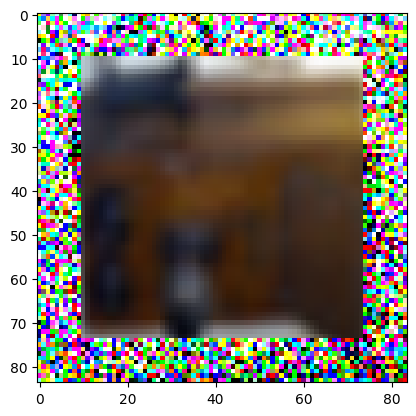

In [31]:
numpy_data = prompted_images[0].cpu().detach().numpy()

plt.imshow(numpy_data.T, cmap="gray")
plt.show()

In [32]:
print("image_preds == ", image_preds)
print("prompt_preds == ", prompt_preds)

image_preds ==  tensor([[-2.4191, -1.8120,  1.0506,  0.6149,  0.0979],
        [-0.6942, -1.3251,  0.8221,  1.5478, -0.3270],
        [ 1.2000, -1.2420,  1.7988,  0.3921,  1.1354],
        [ 1.1042,  0.0233,  1.5148,  1.0245, -0.1710],
        [ 1.7633, -1.2622,  1.7470,  0.7574, -0.5718],
        [ 0.2832, -0.4278,  0.1314,  0.1585,  0.3401],
        [-0.1132, -1.7632,  0.1921,  0.9193, -0.1926],
        [ 0.8875, -0.9736,  1.9524, -0.2551,  0.5114],
        [ 0.0661, -0.5666,  2.0225,  0.1082,  0.0536],
        [-0.4935, -0.5499, -0.1526, -0.7107, -1.7389],
        [-0.4832, -0.1254,  2.5912,  0.3493,  0.2510],
        [-0.7407, -0.3082, -0.3248, -0.7097, -0.2728],
        [ 0.8583, -2.7482, -0.8760,  1.2321,  0.1712],
        [-0.2142, -1.6593, -0.4795,  0.3036, -2.2058],
        [-0.4187, -0.9868, -0.0970,  0.0853,  0.1122],
        [ 1.9608,  0.1885, -1.2654,  0.4584, -0.4603],
        [ 0.2831, -0.8993,  2.0705, -0.8726, -0.3555],
        [-1.4633, -1.0811,  1.8622,  0.0569, -2.8